# Predictive Maintenance Analysis in Python using Pysurvival
This is the predictive maintenance tutorial from the pysurvival docs, which can be found
[here](https://square.github.io/pysurvival/tutorials/maintenance.html).
General idea is so that I can learn some core machine learning concepts alongside pysurvival.

## What is survival analysis?
Put simply, survival analysis is using historical data to predict the probability of an event
happening at any given moment. Good examples of this are:

- Banks, lenders and other financial institutions use it to compute the speed of repayment of
loans or when a borrower will default.
- Businesses adopt it to calculate their customers LTV (lifetime value) or when a client will churn.
- Companies use it to predict when employees will decide to leave.
- Engineers/manufacturers apply it to predict when a machine will break.

Historically, I might have used regression as part of six sigma based approach to predict something
 like mean time to failure and the preceding factors.
However, this ignores the data we have for assets that have not failed in our dataset's timeframe,
 which is just as important as the ones that have.
This is called censoring. Survival models account for this censoring and incorporate the
uncertainty into the model.


## What does this have to do with predictive maintenance?
Well, what if you're running a load of engines all around the world and you're measuring a bunch
of data from those engines. If you knew that an idling
engine RPM of 1250 or more for longer than 5 minutes when the atmospheric temp is above 30 degrees
and coolant temp was above 95 degrees meant that your
radiator was statistically about to break, that would be valuable information. Survival models
should be able to tell us this based on historical data.

## Dataset
The dataset is important, here's our starting dataset.

|Feature category|Feature name|Type|Description|
|--- |--- |--- |--- |
|Time|lifetime|numerical|Number of weeks the machine has been active|
|Event|broken|numerical|Specifies if the machine was broken or hasn't been broken yet for the corresponding weeks in activity|
|IoT measure|pressureInd|numerical|The pressure index is used to quantify the flow of liquid through pipes, as a sudden drop of pressure can indicate a leak|
|IoT measure|moistureInd|numerical|The moisture index is a measure of the relative humidity in the air. It is important to keep track of it as excessive humidity can create mold and damage the equipment|
|IoT measure|temperatureInd|numerical|The temperature index of the machine is computed using voltage devices called thermocouples that translate a change in voltage into temperature measure. It is recorded to avoid damages to electric circuits, fire or even explosion|
|Company feature|team|categorical|This indicator specifies which team is using the machine|
|Machine feature|provider|categorical|This indicator specifies the name of the machine manufacturer|

## Exploratory Data Analysis
Exploratory data analysis is the process of taking a new dataset, figuring out what's in there and
beginning to try and answer some questions. That explanation sucks. Here's a better one.
Exploratory Data Analysis refers to the critical process of performing initial investigations
on data so as to discover patterns,to spot anomalies,to test
hypothesis and to check assumptions with the help of summary statistics and graphical
representations.

Start by loading a sample dataset and seeing what shape it is.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset

# This appears to be some syntactic sugar to load numpy and matplotlib interactively?
# https://ipython.org/ipython-doc/dev/interactive/magics.html
%pylab inline

# Read the dataset.
raw_dataset = Dataset("maintenance").load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3) # Prints the top three rows
raw_dataset.info() # Tells us what type of data we have.

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (1000, 7).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lifetime        1000 non-null   int64  
 1   broken          1000 non-null   int64  
 2   pressureInd     1000 non-null   float64
 3   moistureInd     1000 non-null   float64
 4   temperatureInd  1000 non-null   float64
 5   team            1000 non-null   object 
 6   provider        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


Once we have our data loaded, we need to define it a little and do some transformation for it to work.

Survival analysis is understanding the probability that a given **event** will occur at a given **time**.
So it makes sense that we should have a column where we specify an event has occurred, and another
where we represent time in some manner.


In [2]:
# Define our event and time column names.
time_column = "lifetime"
event_column = "broken"
modelling_features = [time_column, event_column]

### Categorical Data
Some of our data is continuous data (i.e. numbers on a scale), however we also have some categorical data.
In this example dataset the categorical data is shown in the team and provider columns. Categorical data
often cannot be used directly by machine algorithms so we need to make our categories numerical, but there's a catch...

In our example dataset, in the `Team` column, whe have a number of categories representing different teams.
These are finite (in the sense that there are only a limited number of distinct options).

`Team A`
`Team B`
`Team C`
etc.

To transform them into numerical data the algo can understand we could simply attach a number to each one.

`Team A - 1`
`Team B - 2`
`Team C - 3`
etc.

Unfortunately, if we do this the algo may interpret the numbers as having some sort of scale, i.e. 1 is less than 2 etc.
Which makes absolutely no sense given our context. To get around this, we encode the data as one-hot vectors.
This is essentially making each category a binary type number where there is a single 1.

`Team A - 0001`
`Team B - 0010`
`Team C - 0100`

This removes any possible sense of scale between them while keeping them distinct and numerical.

Pandas to the rescue!

In [3]:
# Encode our categorical data as one-hot vectors.
categorical_data = ["provider", "team"]
dataset = pd.get_dummies(raw_dataset, columns=categorical_data, drop_first=True)

# Define our modelling features.
# This gets the set difference of a 1d array.
features = np.setdiff1d(dataset.columns, modelling_features).tolist()


### Is our data in good shape?
One of the things we need to understand very early on is how good is our raw data? At its most basic we need
to know if we have any null values or if there are any duplicated rows.

In [4]:
qty_null = sum(dataset[features].isnull().sum())
print(f"There are {qty_null} null values in our dataset.")

qty_dupes = sum(dataset.duplicated(keep="first"))
print(f"There are {qty_dupes} duplicated rows in the dataset. Removing now.")
dataset = dataset.drop_duplicates(keep="first").reset_index(drop=True)

print(f"There are now {dataset.shape[0]} samples in our dataset.")


There are 0 null values in our dataset.
There are 0 duplicated rows in the dataset. Removing now.
There are now 1000 samples in our dataset.


## Visual exploration and statistics
Lets do the basic stuff first. Boxplots and histograms of each feature.

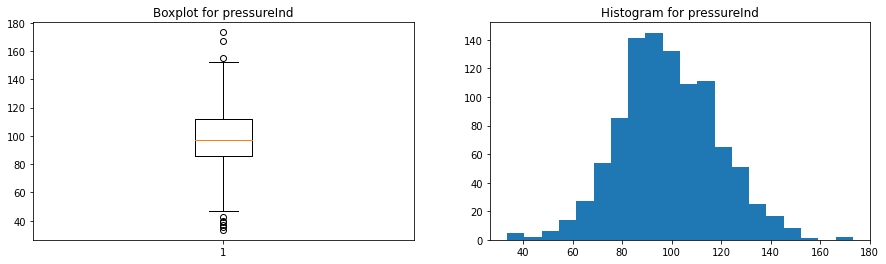

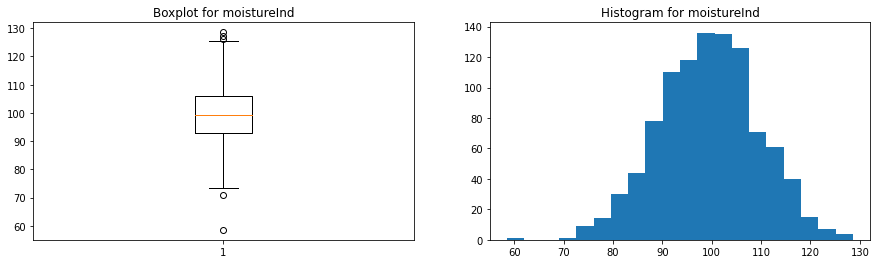

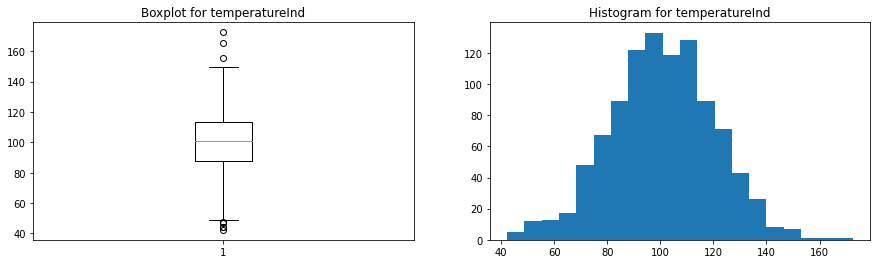

In [5]:
for feature in ["pressureInd", "moistureInd", "temperatureInd"]:
    # Create an empty chart
    fig, (plot_1, plot_2) = plt.subplots(1, 2, figsize=(15, 4))

    # Extract the feature values
    dataset_values = raw_dataset[feature].values

    # Boxplot
    plot_1.boxplot(dataset_values)
    plot_1.set_title(f"Boxplot for {feature}")

    # Histogram
    plot_2.hist(dataset_values, bins=20)
    plot_2.set_title(f"Histogram for {feature}")

    plt.show()

Cool, our data doesn't seem to have any outliers and follows a roughly normal distribution in all cases.
(It's almost as if we're using a made up dataset 🙈). In real life, we may or may not want to remove some
outliers and clean up our data here.

For categorical data, we're gonna do some basic bar charts showing count of occurrences of each record.

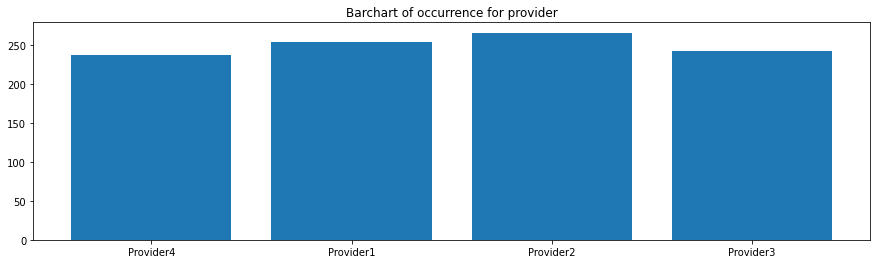

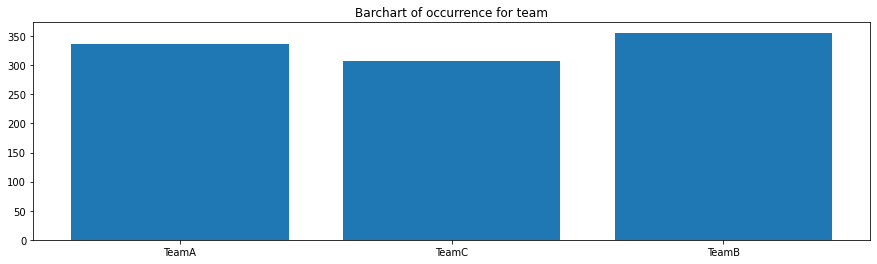

In [6]:
from collections import Counter

for feature in categorical_data:
    fig, chart = plt.subplots(figsize=(15,4))

    # Extract the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    # This is pretty interesting, the Counter class takes an iterable of categorical data and
    # transforms it to a dict of counts (e.g. {"Cat A": 5, "Cat B": 3}).
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    chart.bar(category, counts)

    # Display
    plt.title( 'Barchart of occurrence for {}'.format(feature) )
    plt.show()

This shows us that the number of occurrences of each of our categories are roughly equal.
Nothing to see here...

### Time Series Data
The next thing we want to do is have a look at our time series data. By plotting the occurrences of our
event and normal data we can see this distribution of when our events start happening. We can also
see how much of our data is censored.



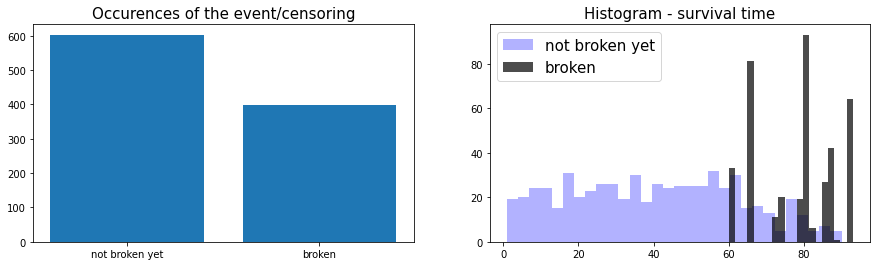

60.3% of our dataset is censored, with 39.7% not censored.


In [7]:
# TODO - This dataset essentially has a binary occurrence of failure vs no failure. In our data
# we have differing failure modes. Should we follow this analysis path and repeat with each
# failure mode separately, or combine them somehow? Are we interested in the relationship between
# failure modes? For example, does a radiator blowout cause an oil gasket leak etc.

# Creating an empty chart
figure, ((chart1, chart2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
# I.e. how much of our data is a positive event occurrence and how much isn't.
chart1.bar(idx, counts)
chart1.set_xticks(idx)
chart1.set_xticklabels(category)
chart1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['broken'] == 0, 'lifetime']
chart2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['broken'] == 1, 'lifetime']
chart2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'broken')
chart2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

# What percentage of our data is censored.
censored = round((counts[0] / (counts[0] + counts[1])) * 100, 2)
not_censored = 100 - censored
print(f"{censored}% of our dataset is censored, with {not_censored}% not censored.")


This tells us that 60% of our dataset is censored and that failures don't start happening until at least the 60
week mark.

### Correlations
The next thing we want to see is whether there are any obvious correlations between our different datasets.
This is useful because there is little point in implementing a machine learning algo if there is a 0.7
correlation between temperature and failure. If that was the case we just use that, job done. Chilling.

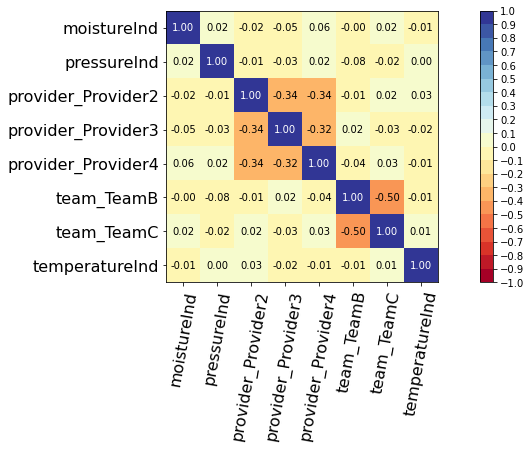

hhh


In [8]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(15, 5))

Again, nothing to see here.

### Modelling
Alright, now for the exciting bit. In order to test that our ML model actually works we're going to need to
set some data aside for testing. We can't just use the same dataset twice because that wouldn't really be
testing.

Luckily, in standard python fashion, somebody has written a func to do this for us.
